#06. PyTorch Transfer Learning

What is transfer learning

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem

* Pretrained model = foundational model


In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


Now we've got the versions of torch and torchvisions, we're after, let's import the code we've written in previous sections so that we don't have to write it all again

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056 (from 1)
Receiving objects: 100% (4056/4056), 646.90 MiB | 28.59 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!nvdia-smi

/bin/bash: line 1: nvdia-smi: command not found


## 1. Get data
We need our pizza, steak, sushi data from PyTorch Hub.

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")


Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
#Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and Dataloaders

Now we've got some data, want to turn it into PyTorch DataLoaders

To do so, we can use 'data_setuo.p' and the "create_dataloaders()' function we made in 05. PyTorch Going Modular.

There's one thing we have to think about when laoding: how to **transform** it?

And with 'torchvision' 0.13+ there's two ways to do this

1. Manually created transforms -you define what transforms you want your data to go through
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important points: when using a pretrained model, its important that the data (inclusing your custom data) that you pass through it is **transformed** in the same way that the data the model was trained on.


In [ ]:
from going_modular.going_modular import data_setup

### 2.1 Creating a transform for "torchvision.models" (manual creation)

In [ ]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [ ]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79e990b081f0>,
 ['pizza', 'steak', 'sushi'])

###2.1 Creating a transform for torchvision

In [ ]:
import torchvision
torchvision.__version__

'0.18.1+cu121'

In [ ]:
#Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
#Get the transforms used to create our pretrained weights
auto_transform  = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
#Create Datalaoders using Automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transform,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79e99089add0>,
 ['pizza', 'steak', 'sushi'])

##Getting a Pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like timm(torch image models)
3. Huggingface hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)


###3.1 Which pretrained model should you use?

*Experiment, experiment, experiment!*

The whole idea of ttransfer learning : take an already well-performing model from a problem space similar to your own and then customize to your own problem

Three things to consider
1. Speed
2. Size
3. Performance

Where does the model live?

Is it on device? (like a self-driving car)

Or on server?
https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

In our case EffNetB0 is one of our best options in terms of performance and size

### 3.2 Settting up  a pretrained model


In [ ]:
#Old method of creating a pretrained model
# model = torchvision.models.efficientnet_b0(pretraine=True).to(device)

#New method of creating a pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 44.4MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a sumamry of model with torch.info.summary()

In [ ]:
from torchinfo import summary

summary (model=model,
         input_size=(1, 3, 224, 224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

###3.4 freezing the base model and changing the output layer to suit your needs

with a feature extraction model typically you will freeze the base layerss of a pretrained model and update the output layers to suit your own problem

In [ ]:
#Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [ ]:
#Update the classifier head of our model to suit the problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary (model=model,
         input_size=(1,3, 224, 224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

#4. Train model

In [ ]:
#Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  #default lr=0.001

In [ ]:
#Import train function
from going_modular.going_modular import engine

#Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Start the timer
from timeit import default_timer as timer
start_time = timer()

#Train model_0
results = engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=5,
             device=device)

#End the timer
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Total training time: 177.342 seconds


## 5. Evaluate the model by Plotting the loss curve

[INFO] Couldn't find helper_function.py, downloading it...


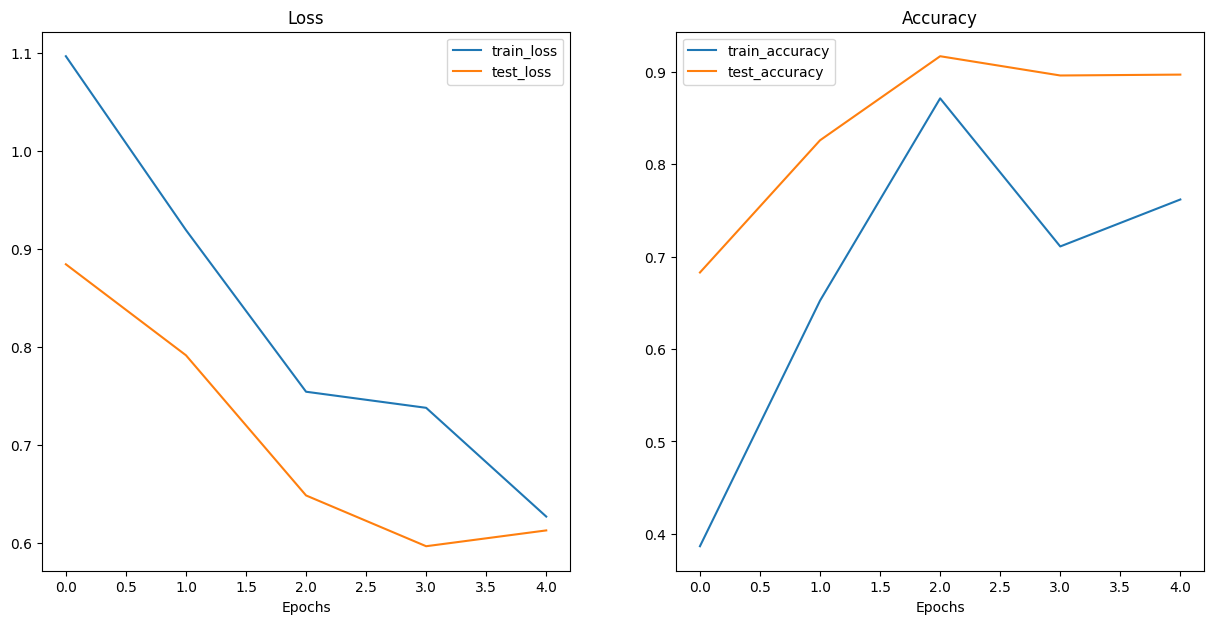

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_function.py, downloading it...")
  with open("helper_function.py", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    print("Downloading helper_function.py...")
    f.write(request.content)
  from helper_function import plot_loss_curves

#Plot the loss curves
plot_loss_curves(results)

What do our los curves look like in terms of our ideal loss curves

See here for more - https://www.learnpytorch.io/04_pytorch_custom_datasets/


##6. Make predictions on  images from the test set

Let's adhere to the data explorer's motto of *visualize, visualize, visualize*!

And make  some qualitative predictions on oour test set.

Some things to keep in mind when making predictions on test data/custom data.

We have to make sure that our test data is:
* Same shape - image need to be same shape  as model model was rained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be in the same data type
* Same transform - if you've transformed your custom data, ideally you will tranform the test data and custom data the same

To do all of this automatically, let's create function called "pred_and_plot_image()"

1. Take in a traine dmodel,  alist of class names, a filepath to a target image, and image size, a transform and a target device
2. Open the image with 'PIL.Image.Open()'
3. Craete a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to 'model.eval()' mode to make sure it's ready for inference (this will turn off things like "nn.Dropout()')
6. Transform the target image and make sure its dimensioanlity is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passig to the model
8. Convert the model's logits to prediction probabilities using 'torch.softmax'
9. Convert model's prediction probailities to prediction labels using 'torch.argmax()'
10. Plot the image with 'matplotlib' and set the title to the prediction label from step 9 and prediction probability from step 8.

In [ ]:
from typing import List, Tuple
from torchvision import transforms
from PIL import Image
from pathlib import Path

import matplotlib.pyplot as plt

#1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        class_names: List[str],
                        image_path: str,
                        image_size: Tuple[int, int] = (224, 224),
                        transform :torchvision.transforms = None,
                        device: torch.device = device):
  #2. Open the image
  img = Image.open(image_path)

  #3. Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

  ### Predict on image ###
  # 4. Make sure the model is on the target device
  model.to(device)

  #5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    #6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
    transformed_image = image_transform(img).unsqueeze(dim=0)

    #7. Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(transformed_image.to(device))

  #8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  #9. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  #10. Plot the image using matplotlib
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);


In [ ]:
# Get a random subset of image path from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_list_subset = random.sample(test_image_path_list, k=num_images_to_plot)
test_image_path_list_subset

#Make predictions on and plot the image
for image_path in test_image_path_list:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

### 6.1 Make a predictions on custom image


In [ ]:
#Downlaod the image
import requests

#Setup custom iamge path
custom_image_path = data_path / "04-pizza-dad.jpeg"

#Download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    #Downlaod image from github with "raw" link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_dad.jpeg")
    print("Downloading custom image...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

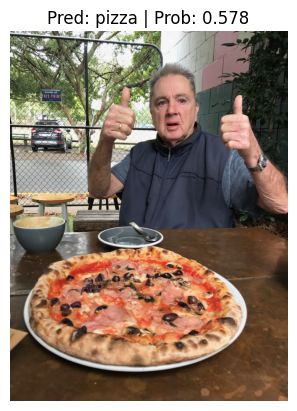

In [ ]:
#Predict on custom image
pred_and_plot_image(model=model,
                     image_path=custom_image_path,
                     class_names=class_names)